In [20]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

Random Seed:  999


/tmp/ipykernel_5836/2216500334.py:48: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## My utils


In [21]:
def img_show(img, cmap="gray", title=""):
    #cv.namedWindow(title, cv.WINDOW_NORMAL)
    #cv.imshow(title, img)
    print(title)
    plt.imshow(img, cmap)
    # display that image
    plt.show()

def tensor_to_image(tensor):
    transform = transforms.ToPILImage()
    return transform(tensor)

def image_to_tensor(image):
    transform_1 = transforms.ToPILImage()
    transform_2 = transforms.ToTensor()
    img_tensor = transform_2(transform_1(image))
    return img_tensor

In [22]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
##Refaire nos data folder et tout pour que ce soit 
#au format demandé par le dataloader


dataroot_source = "/home/jonas/Documents/TER/data/IGBMC_LW4_diversifie/patches"
train_list_source_path = "/home/jonas/Documents/TER/data/IGBMC_LW4_diversifie/patches/test_1000.txt"
# /home/jonas/Documents/TER/data/IGBMC_LW4_diversifie/patches/test_1000.txt
# /home/jonas/Documents/TER/data/IGBMC_I3_diversifie/patches/test_1000.txt



#Some other roots
#Where to save plots, networks weights and final lists values
saving_folder = "../saves/Testing"

path_exists = os.path.exists(saving_folder)
if not path_exists:
    os.mkdir(saving_folder) #We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch

# Number of workers for dataloader
workers = 2

# Batch size during training (low batch_size if there are memory issues)
batch_size = 5

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256 
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 2

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
learning_rate_unet=1e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#some unet variable
amp = False

In [23]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("device ID", device)  #On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("nom du GPU", torch.cuda.get_device_name(device)) #On vérifie son "nom"

number of gpus : 1
device ID cuda:0
nom du GPU NVIDIA GeForce GTX 1080 Ti


In [24]:
log_file = open(saving_folder+"/log.txt", "w")

In [25]:
log_file.write("dataroot_source :"+dataroot_source+"\n")
log_file.write("train_list_source :"+train_list_source_path+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_unet="+str(learning_rate_unet)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")

5

In [26]:
unet = UNet(n_channels=3, n_classes=2, bilinear=False) #bilinear set by default to False here
unet.to(device=device)

#On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

if (device.type == 'cuda') and (ngpu > 1):
    unet = nn.DataParallel(unet, list(range(ngpu)))

We are running U-Net on : NVIDIA GeForce GTX 1080 Ti


In [27]:
log_file.write("dataroot_source :"+dataroot_source+"\n")
log_file.write("train_list_source :"+train_list_source_path+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_unet="+str(learning_rate_unet)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")

5

## Test

250
Base


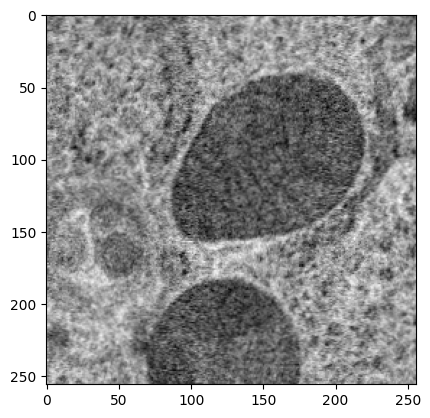

Truth


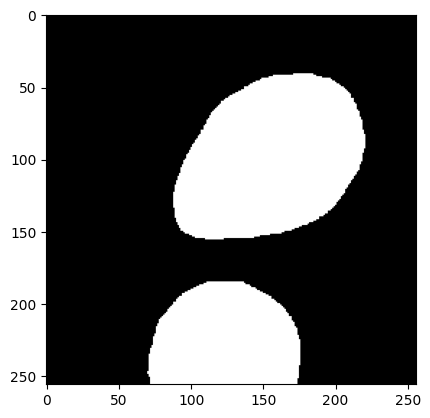

Pred


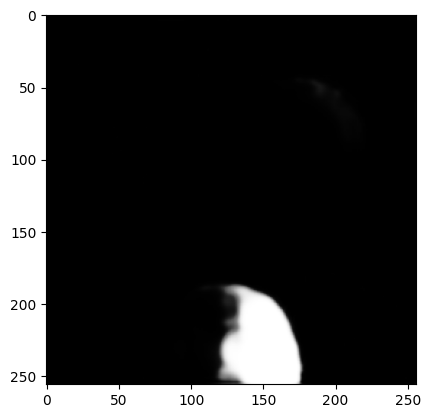

500
Base


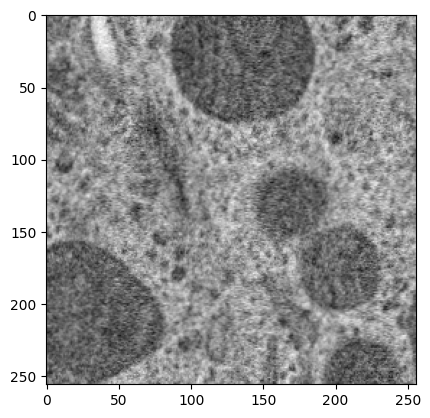

Truth


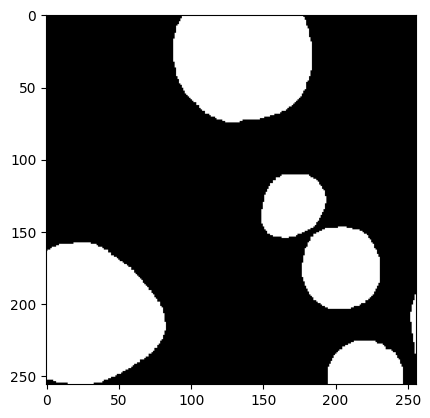

Pred


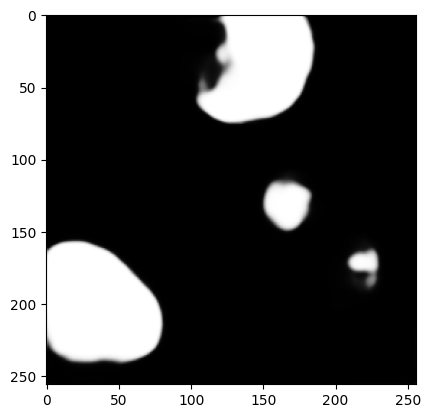

750
Base


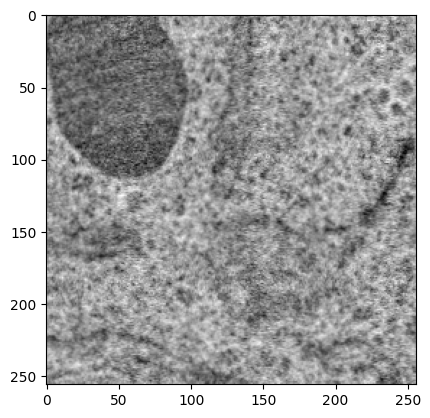

Truth


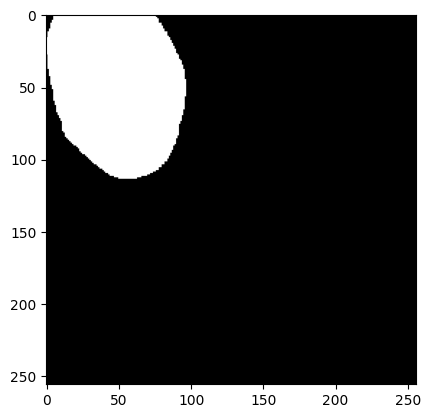

Pred


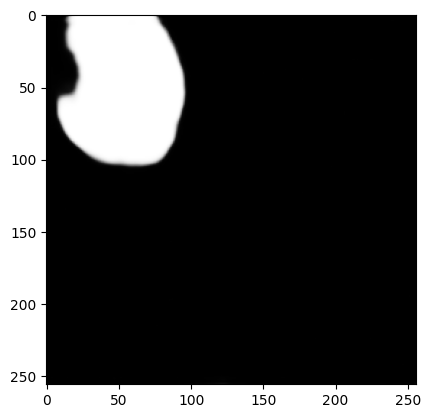

1000
Base


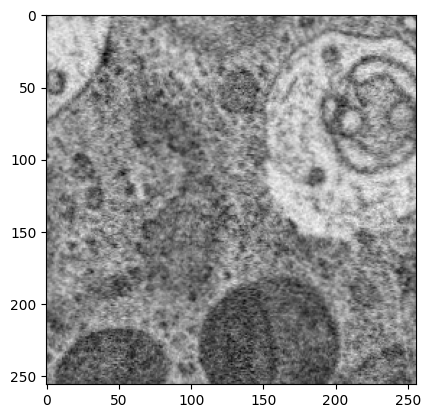

Truth


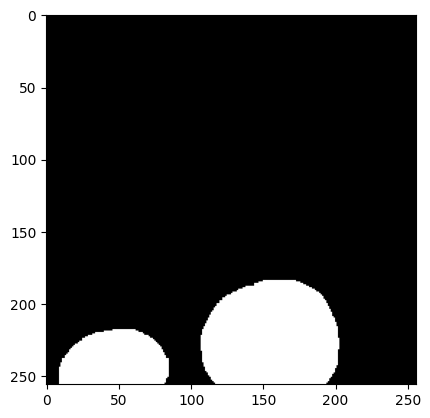

Pred


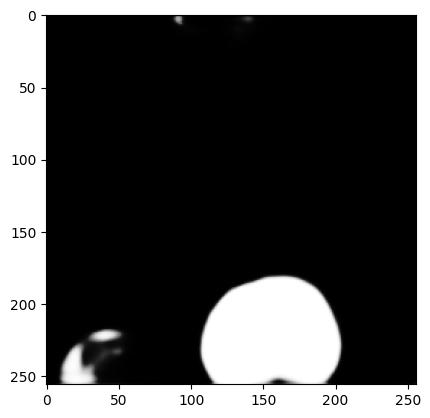

Dice score :  0.0
IoU score :  0.14080517870801074


In [29]:
# Load a trained model
state_dict = torch.load("/home/jonas/Documents/TER/saves/U-Netpatches_I3_2023-01-17_09:28:47/newtork_weigths/UNet_198_epochs.pth")
# /home/jonas/Documents/TER/saves/U-Netpatches_LW4_2023-01-18_13:19:35/newtork_weigths/UNet_84_epochs.pth
# /home/jonas/Documents/TER/saves/U-Netpatches_I3_2023-01-17_09:28:47/newtork_weigths/UNet_198_epochs.pth

unet = UNet(n_channels=3, n_classes=2, bilinear=False)
unet.to(device=device)
unet.load_state_dict(state_dict)
unet.eval()



#Importation des images et masques de i3
dataset_source = SegmentationDataSet(root=dataroot_source,
                                     list_path=train_list_source_path)


count = 0
dice_sum = 0
iou_sum = 0

for data in dataset_source:
    image = data['image']
    mask = data['mask']

    #assert image.shape[1] == unet.n_channels

    source_img = tensor_to_image(image)
    #img_show(source_img, title="Source")

    image = image.to(device=device, dtype=torch.float32)
    mask = mask.to(device=device, dtype=torch.long)

    with torch.no_grad() :
        count += 1


        pred = unet(image[None,...].to(device))[0]        

        prediction_img = F.softmax(pred, dim=0).float().cpu()[1]
        #img_show(tensor_to_image(prediction_img), title="Pred")

        truth_img = mask.float().cpu()
        #img_show(tensor_to_image(truth_img), title="Truth")

        
        #print(truth_img.shape)
        


        #dice_sum += dice_coeff(F.softmax(pred, dim=1).float(), 
        #                        F.one_hot(truth_img[:,0,:,:], unet.n_classes).permute(0, 3, 1, 2).float()).item()
        
        

        if (count%250==0):
            print(count)
            img_show(tensor_to_image(image), title="Base")
            img_show(tensor_to_image(truth_img), title="Truth")
            img_show(tensor_to_image(prediction_img), title="Pred")

        iou = IoU(prediction_img.numpy(), 
                    truth_img.numpy()).item()
        iou_sum += iou

        # IOU |Produit| / |Somme|
        # A U B = normalisation => Max puis somme
        # A N B = Min puis somme
        # Sklearn = similarité de jaccard : voir


print("Dice score : ", dice_sum/count)
print("IoU score : ", iou_sum/count)



